In [34]:
from desc.transform import Transform
from desc.equilibrium import Equilibrium
from desc.basis import ChebyshevZernikeBasis, chebyshev_z
from desc.compute import compute
from desc.grid import LinearGrid, ConcentricGrid, QuadratureGrid, Grid
from desc.compute.utils import get_transforms
from desc.objectives import (
    FixEndCapLambda,
    FixEndCapR,
    FixEndCapZ,
    FixBoundaryR,
    FixBoundaryZ,
    FixPsi,
    FixPressure,
    FixIota,
    ForceBalance,
    ObjectiveFunction,
    CurrentDensity
)
import numpy as np
from desc.optimize import Optimizer
from desc.profiles import PowerSeriesProfile
from desc.geometry import FourierRZToroidalSurface
from desc.plotting import plot_section, plot_3d, plot_surfaces, plot_2d, plot_boundary

In [65]:
def chebygrid(N_grid):
    return np.concatenate( ([0],(-np.cos( (2 * np.arange(N_grid) + 1) * np.pi / (2 *  N_grid) ) + 1) * np.pi ,[2*np.pi]))
def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid,M=M_grid,N=0, node_pattern=node_pattern).nodes[:,:2]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size,1))
    n = np.tile(Nnodes.reshape(-1,1), (1, LMnodes.shape[0])).reshape(-1,1)
    nodes = np.concatenate((lm,n), axis=1)
    return Grid(nodes)

# Import tests

In [83]:
from scipy.constants import mu_0

In [102]:
surf = FourierRZToroidalSurface(
    R_lmn=[10,1,-0.1],
    modes_R=[[0,0],[1,0],[1,2]],
    Z_lmn=[0,-1,0.1],
    modes_Z=[[0,0],[-1,0],[-1,2]],
    NFP=1,
    sym=False,
    mirror=True
)

p = PowerSeriesProfile(params=[0, 0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0, 0])
eq = Equilibrium(
    surface=surf,
    L=5,
    M=1,
    N=6,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
    method="jitable",
)

constraints = (
        FixEndCapLambda(0, eq=eq),
        FixEndCapR(0, eq.eq),
        FixEndCapZ(0, eq=eq),
        FixEndCapLambda(2*np.pi, eq=eq),
        FixEndCapR(2*np.pi, eq=eq),
        FixEndCapZ(2*np.pi, eq=eq),
        FixBoundaryR(eq=eq),
        FixBoundaryZ(eq=eq),
        FixPressure(eq=eq),
        FixIota(eq=eq),
        FixPsi(eq=eq),
    )
optimizer = Optimizer("lsq-exact")
grid = grid_gen(10,2,10)
# objectives = CurrentDensity(eq=eq, grid=grid)
objectives = ForceBalance(eq=eq, grid=grid)
obj = ObjectiveFunction(objectives=objectives)

In [103]:
eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
);

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 105
Number of objectives: 432
Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 1.416e-05
         Total delta_x: 2.386e-01
         Iterations: 84
         Function evaluations: 96
         Jacobian evaluations: 85
Start of solver
Total (sum of squares):  5.565e-05, 
Maximum absolute Force error:  8.937e+03 (N)
Minimum absolute Force error:  1.318e-12 (N)
Average absolute Force error:  1.719e+03 (N)
Maximum absolute Force error:  5.615e-04 (normalized)
Minimum absolute Force error:  8.281e-20 (normalized)
Average absolute Force error:  1.080e-04 (normalized)
End of solver
Total (sum of squares):  1.416e-05, 
Maximum absolute Force error:  5.864e+03 (N)
Minimum absolute Force error:  5.665e-01 (N)
Average absolute Force error:  1.019e+03 (N)
Maximum absolute Force er

(<Figure size 1079.13x719.422 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Ax

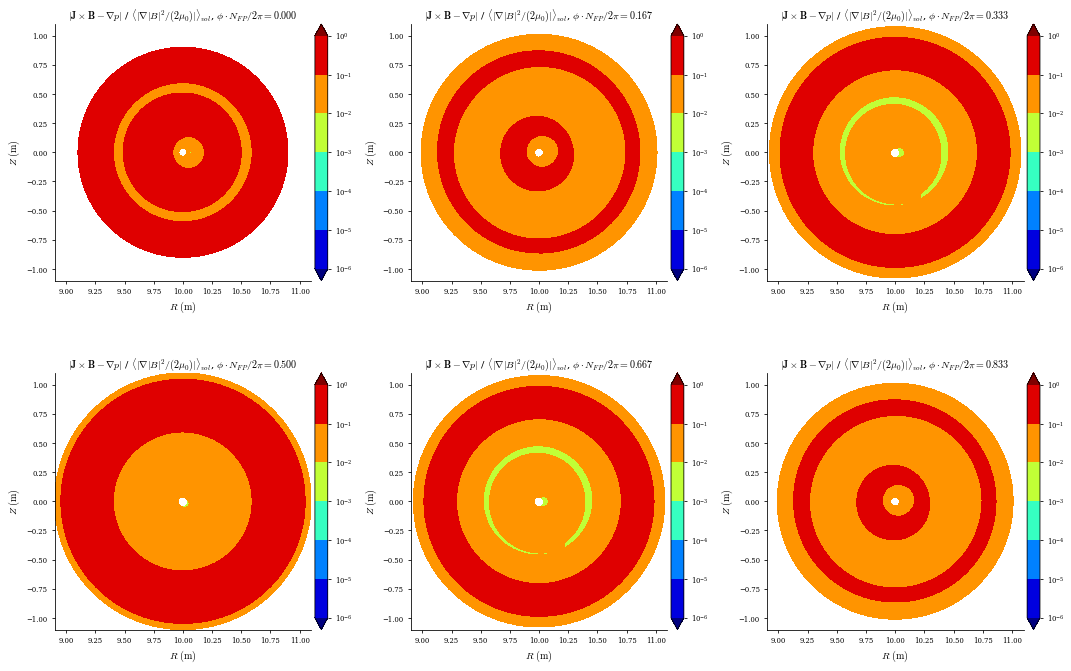

In [104]:
plot_section(eq, "|F|", norm_F=True, log=True)

# Compute tests

In [28]:
grid = LinearGrid(L=3,M=3,N=3)

In [33]:
tranf = Transform(basis=eq.R_basis,grid=grid,method="jitable")
# jitable is direct1

In [40]:
get_transforms("B",eq,grid,jitable=True)

{'grid': LinearGrid at 0x291c07d50 (L=3, M=3, N=3, NFP=1, sym=False, node_pattern=linear),
 'R': Transform at 0x293124350 (method=jitable, basis=ChebyshevZernikeBasis at 0x17f9a5890 (L=3, M=3, N=3, NFP=1, sym=False, spectral_indexing=ansi), grid=LinearGrid at 0x291c07d50 (L=3, M=3, N=3, NFP=1, sym=False, node_pattern=linear)),
 'Z': Transform at 0x293195c90 (method=jitable, basis=ChebyshevZernikeBasis at 0x17f7c8590 (L=3, M=3, N=3, NFP=1, sym=False, spectral_indexing=ansi), grid=LinearGrid at 0x291c07d50 (L=3, M=3, N=3, NFP=1, sym=False, node_pattern=linear)),
 'L': Transform at 0x29315acd0 (method=jitable, basis=ChebyshevZernikeBasis at 0x174a4da90 (L=3, M=3, N=3, NFP=1, sym=False, spectral_indexing=ansi), grid=LinearGrid at 0x291c07d50 (L=3, M=3, N=3, NFP=1, sym=False, node_pattern=linear))}

In [42]:
eq.compute("B")["B"]

Array([[0.        , 0.31830989, 0.        ],
       [0.        , 0.31830989, 0.        ],
       [0.        , 0.31830989, 0.        ],
       ...,
       [0.        , 0.31830989, 0.        ],
       [0.        , 0.31830989, 0.        ],
       [0.        , 0.31830989, 0.        ]], dtype=float64)